In [1]:
# common
import os
import keras
import numpy as np
from glob import glob
import tensorflow as tf
import tensorflow.image as tfi
from keras.preprocessing.image import load_img, img_to_array
from tensorflow.keras.utils import to_categorical

# Data Viz
import matplotlib.pyplot as plt

# Model 
from keras.models import Model
from keras.layers import Layer
from keras.layers import Conv2D
from keras.layers import Dropout
from keras.layers import UpSampling2D
from keras.layers import concatenate
from keras.layers import Add
from keras.layers import Multiply
from keras.layers import Input
from keras.layers import MaxPool2D
from keras.layers import BatchNormalization

# Callbacks 
from keras.callbacks import Callback
from keras.callbacks import EarlyStopping
from keras.callbacks import ModelCheckpoint

# Metrics
from keras.metrics import MeanIoU

2024-06-01 18:40:39.634372: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-06-01 18:40:41.840495: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


# **Encoder**

In [2]:
class EncoderBlock(Layer):

    def __init__(self, filters, rate, pooling=True, **kwargs):
        super(EncoderBlock, self).__init__(**kwargs)

        self.filters = filters
        self.rate = rate
        self.pooling = pooling

        self.c1 = Conv2D(filters, kernel_size=3, strides=1, padding='same', activation='relu', kernel_initializer='he_normal')
        self.drop = Dropout(rate)
        self.c2 = Conv2D(filters, kernel_size=3, strides=1, padding='same', activation='relu', kernel_initializer='he_normal')
        self.pool = MaxPool2D()

    def call(self, X):
        x = self.c1(X)
        x = self.drop(x)
        x = self.c2(x)
        if self.pooling:
            y = self.pool(x)
            return y, x
        else:
            return x

    def get_config(self):
        base_config = super().get_config()
        return {
            **base_config,
            "filters":self.filters,
            'rate':self.rate,
            'pooling':self.pooling
        }

# **Decoder**

In [3]:
class DecoderBlock(Layer):

    def __init__(self, filters, rate, **kwargs):
        super(DecoderBlock, self).__init__(**kwargs)

        self.filters = filters
        self.rate = rate

        self.up = UpSampling2D()
        self.net = EncoderBlock(filters, rate, pooling=False)

    def call(self, X):
        X, skip_X = X
        x = self.up(X)
        c_ = concatenate([x, skip_X])
        x = self.net(c_)
        return x

    def get_config(self):
        base_config = super().get_config()
        return {
            **base_config,
            "filters":self.filters,
            'rate':self.rate,
        }

# **Attention Gate**

In [4]:
class AttentionGate(Layer):

    def __init__(self, filters, bn, **kwargs):
        super(AttentionGate, self).__init__(**kwargs)

        self.filters = filters
        self.bn = bn

        self.normal = Conv2D(filters, kernel_size=3, padding='same', activation='relu', kernel_initializer='he_normal')
        self.down = Conv2D(filters, kernel_size=3, strides=2, padding='same', activation='relu', kernel_initializer='he_normal')
        self.learn = Conv2D(1, kernel_size=1, padding='same', activation='sigmoid')
        self.resample = UpSampling2D()
        self.BN = BatchNormalization()

    def call(self, X):
        X, skip_X = X

        x = self.normal(X)
        skip = self.down(skip_X)
        x = Add()([x, skip])
        x = self.learn(x)
        x = self.resample(x)
        f = Multiply()([x, skip_X])
        if self.bn:
            return self.BN(f)
        else:
            return f
        # return f

    def get_config(self):
        base_config = super().get_config()
        return {
            **base_config,
            "filters":self.filters,
            "bn":self.bn
        }

2024-06-01 18:44:14.272693: E external/local_xla/xla/stream_executor/cuda/cuda_driver.cc:282] failed call to cuInit: CUDA_ERROR_UNKNOWN: unknown error
2024-06-01 18:44:14.272770: I external/local_xla/xla/stream_executor/cuda/cuda_diagnostics.cc:134] retrieving CUDA diagnostic information for host: nixon
2024-06-01 18:44:14.272792: I external/local_xla/xla/stream_executor/cuda/cuda_diagnostics.cc:141] hostname: nixon
2024-06-01 18:44:14.272978: I external/local_xla/xla/stream_executor/cuda/cuda_diagnostics.cc:165] libcuda reported version is: 550.67.0
2024-06-01 18:44:14.273024: I external/local_xla/xla/stream_executor/cuda/cuda_diagnostics.cc:169] kernel reported version is: 550.67.0
2024-06-01 18:44:14.273042: I external/local_xla/xla/stream_executor/cuda/cuda_diagnostics.cc:248] kernel version seems to match DSO: 550.67.0
/mnt/research/Physics-Informed-Neural-Networks-for-Quantum-Dynamics/.mamba/envs/pytorch/lib/python3.12/site-packages/keras/src/layers/layer.py:361: UserWarning: `bu

1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step


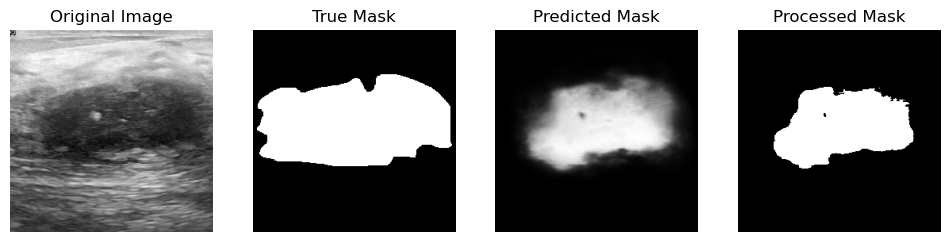

Percentage of white area: 18.951416015625
Classification Result: Cancer


In [5]:
import tensorflow as tf
from tensorflow.keras.models import load_model
import matplotlib.pyplot as plt
import numpy as np

# Load the model
model = load_model("BreastCancerAttentionUNet.h5", custom_objects={
    'MeanIoU': tf.keras.metrics.MeanIoU,
    'EncoderBlock': EncoderBlock,
    'DecoderBlock': DecoderBlock,
    'AttentionGate': AttentionGate
})

def preprocess_image(image_path, size):
    img = tf.keras.preprocessing.image.load_img(image_path, target_size=(size, size))
    img = tf.keras.preprocessing.image.img_to_array(img)
    img = np.expand_dims(img, axis=0)  # Add batch dimension
    return img / 255.0  # Normalize to [0, 1]

def calculate_white_percentage(processed_mask):
    white_pixels = np.sum(processed_mask > 0.5)
    total_pixels = processed_mask.size
    white_percentage = (white_pixels / total_pixels) * 100
    return white_percentage

def classify_cancer(processed_mask):
    white_percentage = calculate_white_percentage(processed_mask)
    if white_percentage > 1:
        print("Percentage of white area:", white_percentage)
        return "Cancer"
    else:
        print("Percentage of white area:", white_percentage)
        return "Non-Cancer"
SIZE = 256
# Load and preprocess an image and its mask
image_path = 'malignant (1).png'
mask_path = 'malignant (1)_mask.png'
#image_path = '/kaggle/input/breast-ultrasound-images-dataset/Dataset_BUSI_with_GT/malignant/malignant (1).png'
#mask_path = '/kaggle/input/breast-ultrasound-images-dataset/Dataset_BUSI_with_GT/malignant/malignant (1)_mask.png'
image = preprocess_image(image_path, SIZE)
mask = preprocess_image(mask_path, SIZE)

# Predict the mask
predicted_mask = model.predict(image)

# Visualize the results
def show_results(img, true_mask, pred_mask, processed_mask_threshold=0.5):
    plt.figure(figsize=(12, 4))
    
    plt.subplot(1, 4, 1)
    plt.title("Original Image")
    plt.imshow(tf.squeeze(img), cmap='gray')
    plt.axis('off')
    
    plt.subplot(1, 4, 2)
    plt.title("True Mask")
    plt.imshow(tf.squeeze(true_mask), cmap='gray')
    plt.axis('off')
    
    plt.subplot(1, 4, 3)
    plt.title("Predicted Mask")
    plt.imshow(tf.squeeze(pred_mask), cmap='gray')
    plt.axis('off')
    
    plt.subplot(1, 4, 4)
    plt.title("Processed Mask")
    processed_mask = (pred_mask > processed_mask_threshold).astype(np.float32)
    plt.imshow(tf.squeeze(processed_mask), cmap='gray')
    plt.axis('off')
    
    plt.show()

# Show the images
show_results(image, mask, predicted_mask)
classification_result = classify_cancer(predicted_mask)
print("Classification Result:", classification_result)